In [6]:
from transformers import SamModel, SamProcessor
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'

(1920, 1080)


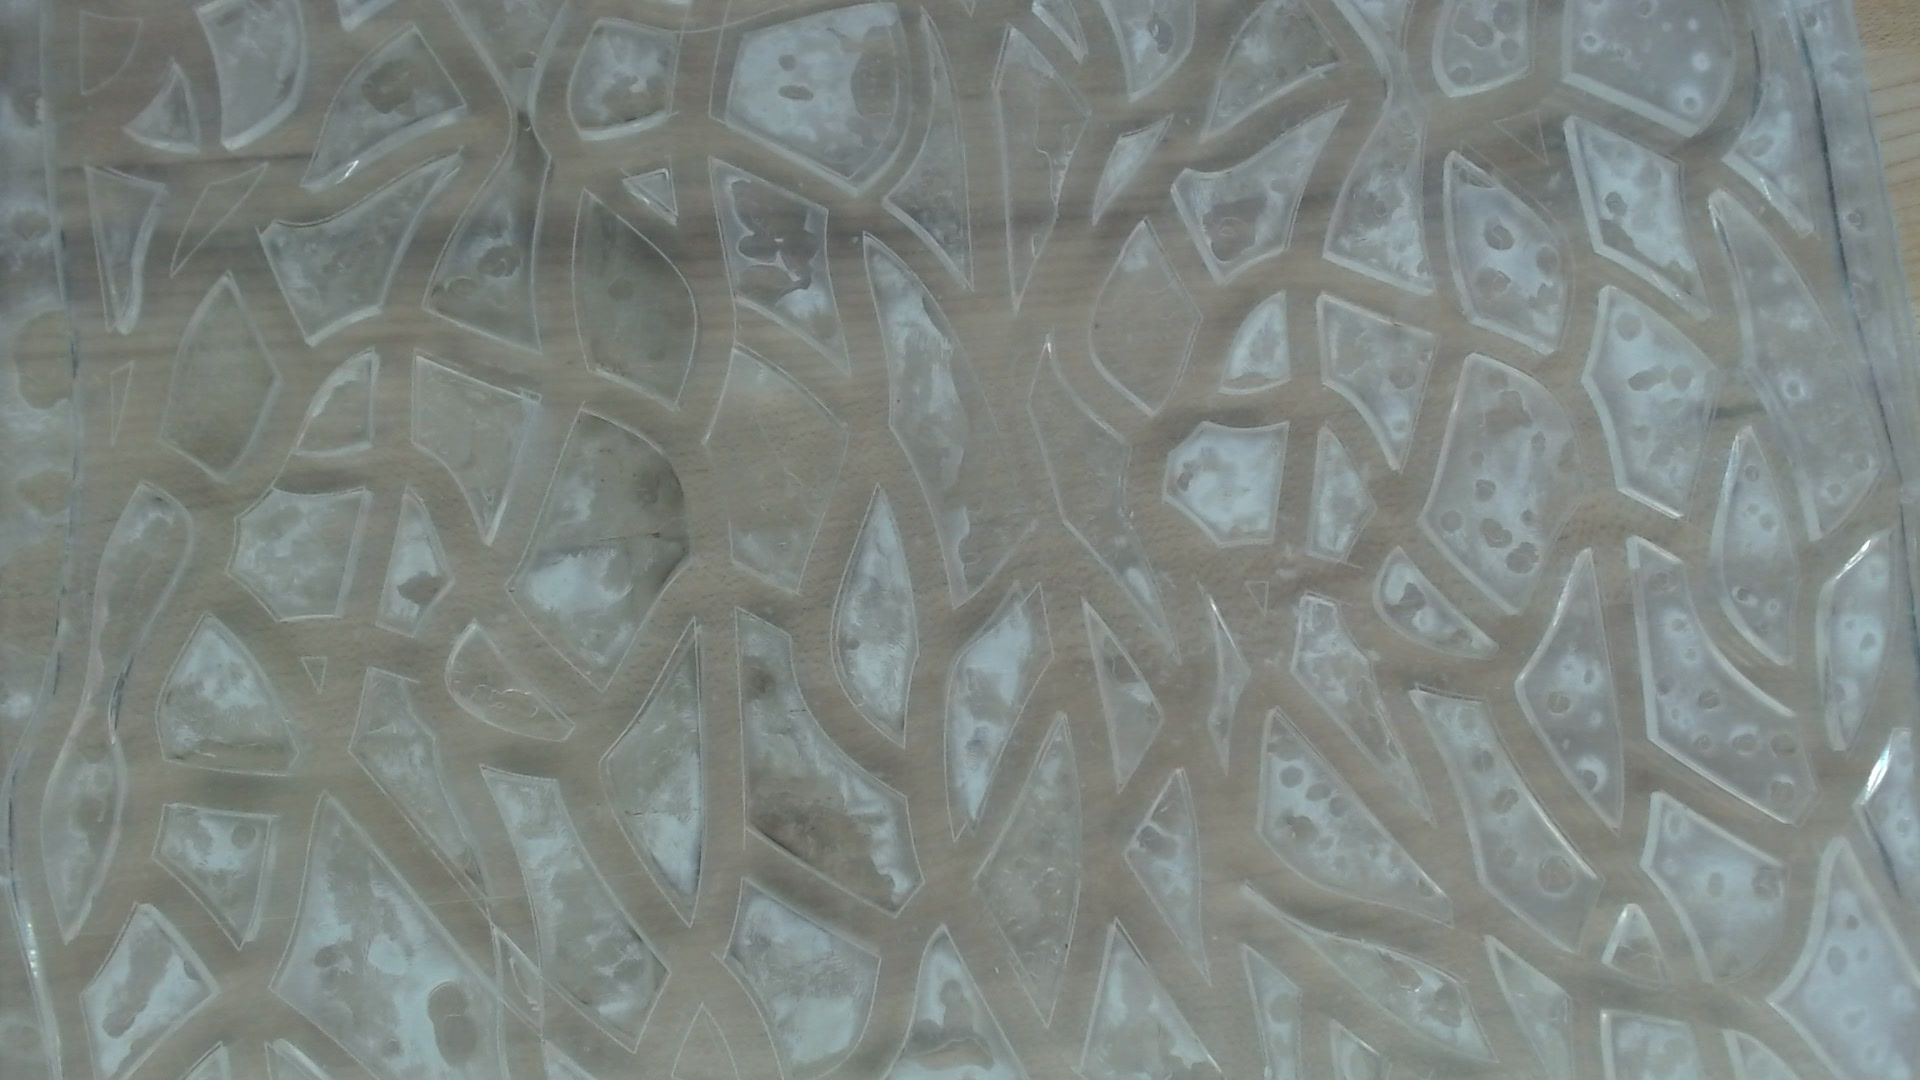

In [7]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = Image.open("../../Data/Datasets/RigidModelVideo-11-21/11-21-1-clip0/frame0001.jpg")
print(image.size)
image

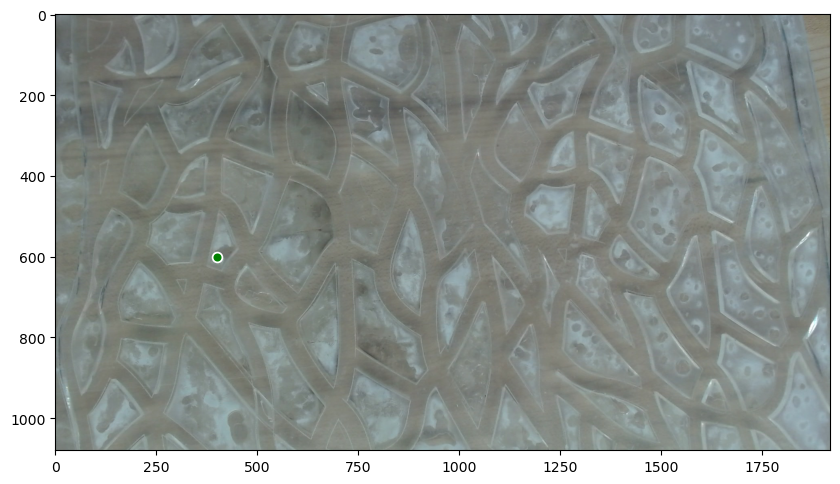

In [8]:
# Util functions from https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

show_points_on_image(image, [[400,600]])

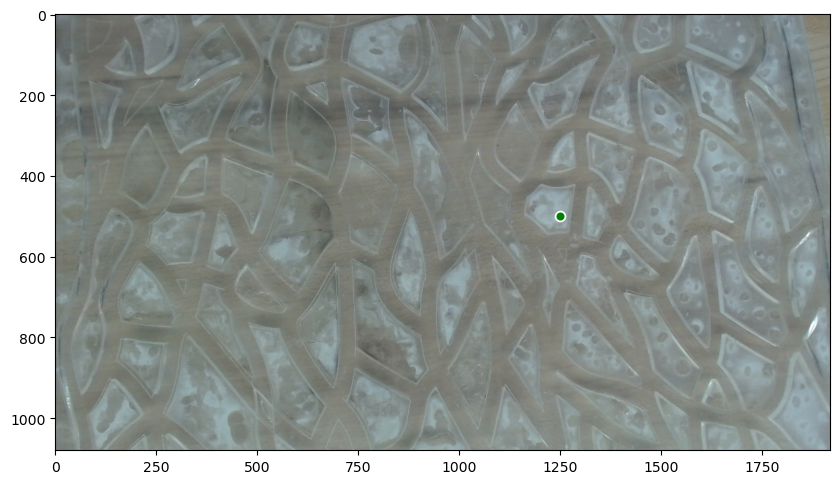

torch.Size([1, 3, 1080, 1920])


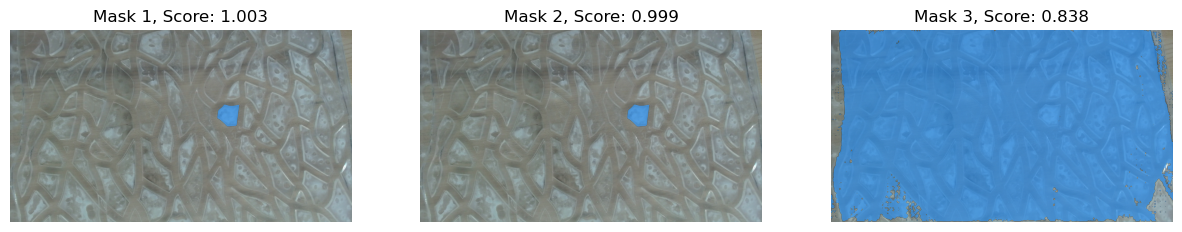

In [9]:
import pathlib


model = SamModel.from_pretrained('facebook/sam-vit-huge').to(device)
processor = SamProcessor.from_pretrained('facebook/sam-vit-huge')


test_point = [[[1250,500]]]
show_points_on_image(image, test_point[0])

inputs = processor(image, input_points=test_point, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores.cpu()
print(masks[0].shape)
show_masks_on_image(image, masks[0], scores)
mask_image = masks[0].cpu().detach().numpy()[0].astype(np.uint8)

In [10]:
cv2.imwrite("./mask1.png", mask_image[0]*255)
np.count_nonzero(mask_image[0])

11826

(364, 1, 2)


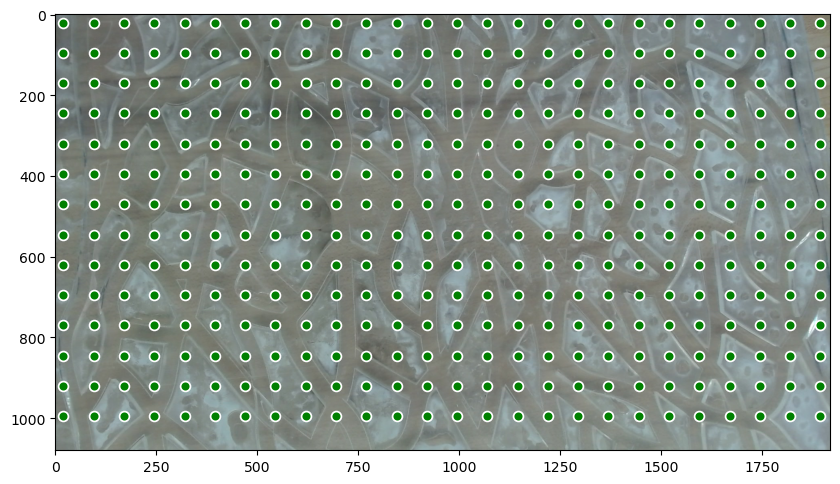

In [11]:
# Explore automatic generation of points:
def generate_points(image, bounding_box=[(20,20), (1900, 1060)], step=100):
    points = [[x,y] for x in range(bounding_box[0][0], bounding_box[1][0], step) for y in range(bounding_box[0][1], bounding_box[1][1], step)]
    return [[point] for point in points]

points = generate_points(image, bounding_box=[(20,20), (1900, 1060)], step=75)
print(np.shape(points))
show_points_on_image(image, np.swapaxes(points, 0, 1)[0])  

In [12]:
inputs = processor(image, return_tensors="pt").to(device)
image_embedding = model.get_image_embeddings(inputs['pixel_values'])
inputs = processor(image, input_points=[points], return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({'image_embeddings': image_embedding})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores


torch.Size([1, 364, 3])


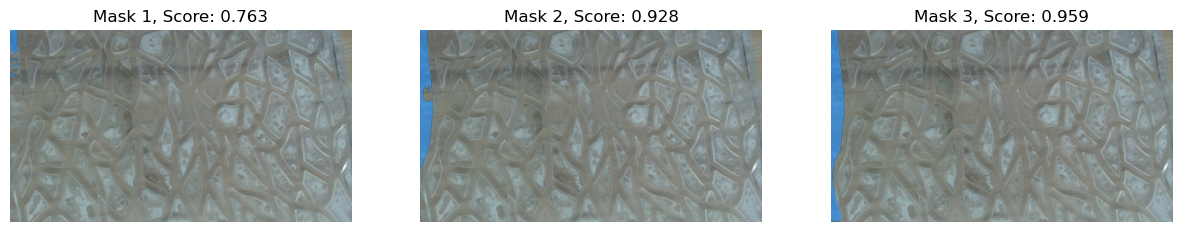

In [13]:
print(scores.shape)
show_masks_on_image(image, masks[0][:1], scores[:, :1, :])

In [14]:
# Print hist of scores and mask sizes:
image_masks = masks[0].cpu().detach().numpy()
image_scores = scores[0].cpu().detach().numpy()

Text(0, 0.5, 'Frequency')

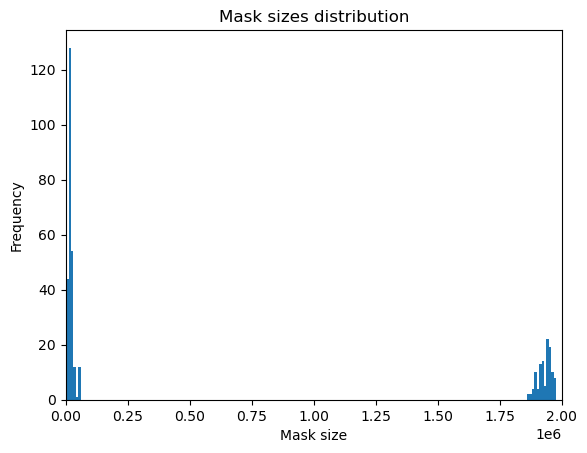

In [15]:
optimal_masks = [image_masks[i][np.argmax(image_scores[i])] for i in range(image_masks.shape[0])]
mask_sizes = [np.count_nonzero(mask) for mask in optimal_masks]
plt.hist(mask_sizes, bins=200)
plt.title("Mask sizes distribution")
plt.xlim(0, 2e6)
plt.xlabel("Mask size")
plt.ylabel("Frequency")

Definintely can apply thresholding to find all valid masks.

In [16]:
def otsu(hist):
    total = sum(hist)
    sumB = 0
    wB = 0
    maximum = 0.0
    sum1 = sum([i*j for i,j in enumerate(hist)])
    for i in range(0, len(hist)):
        wB += hist[i]
        wF = total - wB
        if wB == 0 or wF == 0:
            continue
        sumB += i * hist[i]
        mB = sumB / wB
        mF = (sum1 - sumB) / wF
        varBetween = wB * wF * (mB - mF) ** 2
        if varBetween > maximum:
            maximum = varBetween
            level = i
    return level

hist, bin_edges = np.histogram(mask_sizes, bins=1000)
bin_edges[otsu(hist)]

58025.865

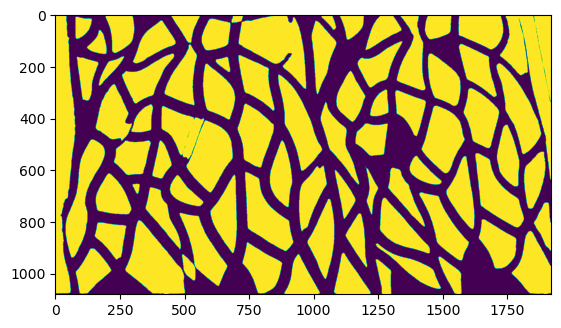

In [17]:
#Suppose devide is 100000:

final_mask_stack = np.array(optimal_masks)[np.array(mask_sizes) < 100000]
final_mask = final_mask_stack.any(axis=0).astype(np.uint8)
plt.imshow(final_mask)


Very fresh, very delicious.
Now we do fine-tuning

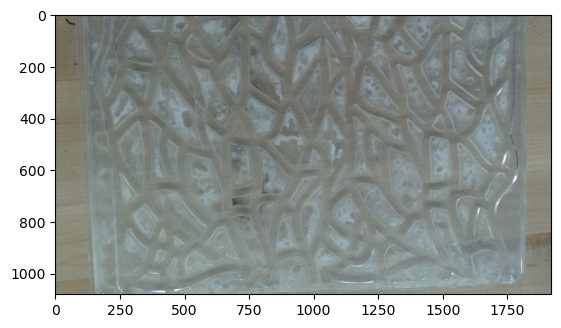

In [19]:
image1 = Image.open("../../Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/frame0001.jpg")
plt.imshow(image1)

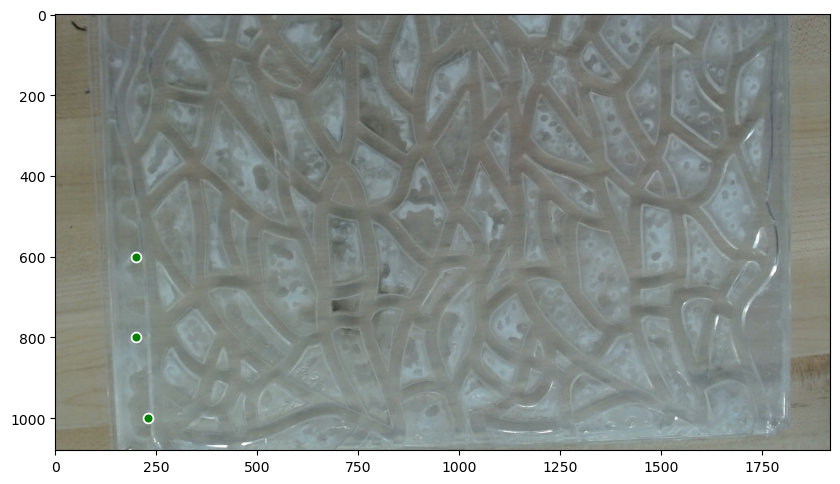

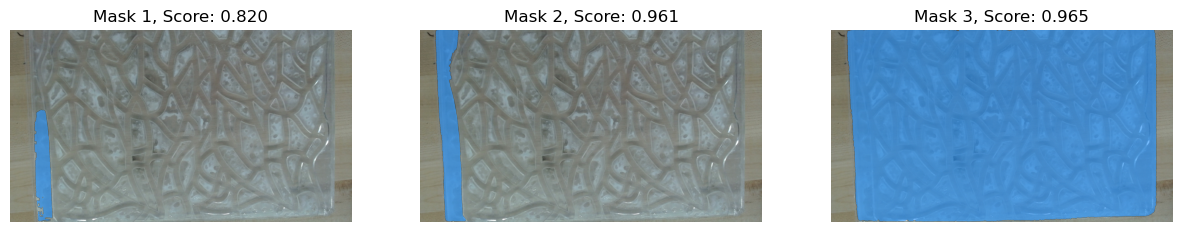

In [20]:
points = [[[200, 800], [200,600], [230, 1000]]]
show_points_on_image(image1, points[0])

inputs = processor(image1, input_points=points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
show_masks_on_image(image1, masks[0], scores)    